In [151]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import glob
import pickle
from IPython.display import display, Latex
import logomaker

import adabmDCA
from adabmDCA.functional import one_hot
from adabmDCA.utils import get_device, get_dtype

import sys
sys.path.append('..')
import selex_dca
import utils

In [33]:
device = get_device("")
dtype = get_dtype("float32")

Running on CPU


In [18]:
data = []

for filepath in sorted(glob.iglob('./saved/*.pkl')):
    if filepath[8:11] == 'Dop':
        with open(filepath, 'rb') as f:
            data.append(pickle.load(f))

print(f"Loaded {len(data)} files.")

data = [data[i] for i in [0,2,1]]

experiment_ids, round_ids_all, params_all = zip(*data)

Loaded 3 files.


In [55]:
def allequal(x):
    return x.count(x[0]) == len(x)

assert(allequal(round_ids_all))

round_ids = round_ids_all[0]
ts = range(len(round_ids))
ns = range(len(experiment_ids))

In [44]:
params_zerosum_all = [utils.set_zerosum_gauge(params_all[n])
                      for n in range(len(params_all))]

<IPython.core.display.Latex object>

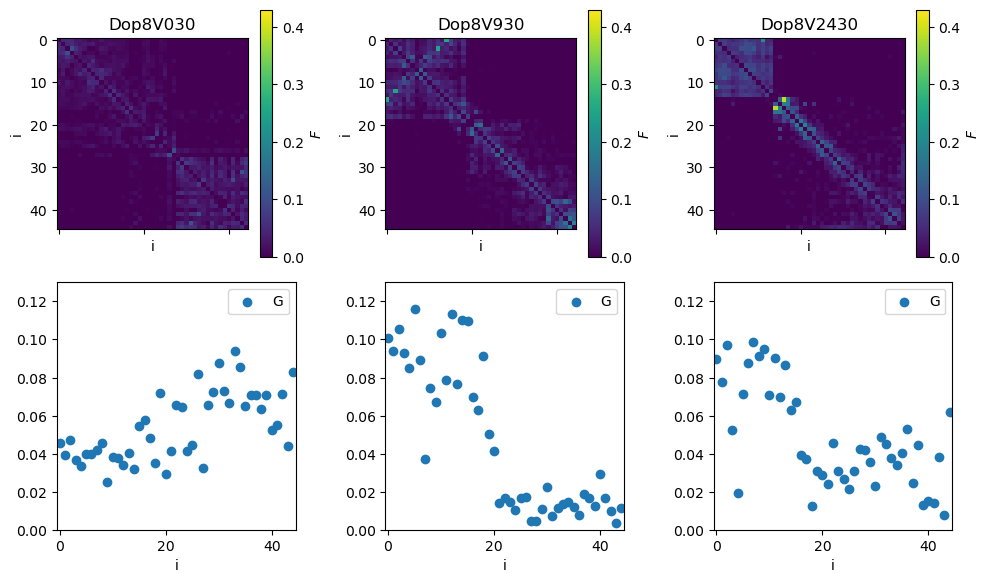

In [145]:
pl, axes = plt.subplots(2, 3, figsize=(10,6), sharex=True)
for n in range(len(experiment_id_all)):
    ax = axes[0,n]
    F = selex_dca.get_contact_map(params_zerosum_all[n]["couplings_ps"])
    im = ax.imshow(F)
    ax.set_xlabel("i"); ax.set_ylabel("i")
    ax.set_title(experiment_id_all[n])
    plt.colorbar(im, label="$F$")
    im.set_clim(0,0.43)
    ax = axes[1,n]
    G = torch.sqrt(torch.square(params_zerosum_all[n]["bias_ps"]).sum(dim=1))
    ax.scatter(range(len(G)), G, label="G")
    ax.set_xlabel("i")
    ax.set_ylim((0,0.13))
    ax.legend()
plt.tight_layout()
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2},\\quad G_i = \\sqrt {\\sum_a (h_i^a)^2}$"))
plt.savefig('img/couplings.png')

## Load datasets

In [51]:
import importlib

importlib.reload(selex_dca)

<module 'selex_dca' from '/home/scrotti/Aptamer2025py/experiments/../selex_dca.py'>

In [110]:
import gc

def run_and_save(n, N):
    print(f'Starting dataset {n}...')
    sequences_n = [selex_dca.sequences_from_file(experiment_ids[n], round_id, device) for round_id in round_ids]
    # Compute logNst of sequences in dataset n with parameters learned from dataset n, except use the Ns0
    #  learned from dataset n
    logNst_n, sequences_unique_n, sequences_unique_oh_n, inverse_indices_n, counts_n = zip(*[
        selex_dca.compute_logNst(
            sequences_n, params=params_zerosum_all[m], params_Ns0=params_zerosum_all[n]
            ) for m in ns]
    )

    pearsons_n = [[torch.corrcoef(torch.stack((logNst_n[m][t],logNst_n[n][t])))[0,1] 
               for t in ts] for m in ns]

    idx = [random.sample(range(len(logNst_n[0][t])), min(N,len(logNst_n[0][t])))  for t in ts]
    X_n, Y_n = zip(*[zip(*[(logNst_n[m][t][idx[t]], logNst_n[n][t][idx[t]]) for t in ts]) for m in ns])
    
    filename = experiment_ids[n] + ".pkl"
    filepath = "saved/plot_Nst/" + filename
    
    data = [pearsons_n, X_n, Y_n]
    
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)

    print(f'Finished dataset {n}')
    gc.collect()

In [111]:
N = 10**4

for n in ns:
    run_and_save(n, N)

Starting dataset 0...
Finished dataset 0
Starting dataset 2...
Finished dataset 2


## Load

In [120]:
data = []

for filepath in sorted(glob.iglob('./saved/plot_Nst/*.pkl')):
    print('File ' + filepath)
    with open(filepath, 'rb') as f:
        data.append(pickle.load(f))

print(f"Loaded {len(data)} files.")

data = [data[i] for i in [0,2,1]]

pearsons, X, Y = zip(*data)

File ./saved/plot_Nst/Dop8V030.pkl
File ./saved/plot_Nst/Dop8V2430.pkl
File ./saved/plot_Nst/Dop8V930.pkl
Loaded 3 files.


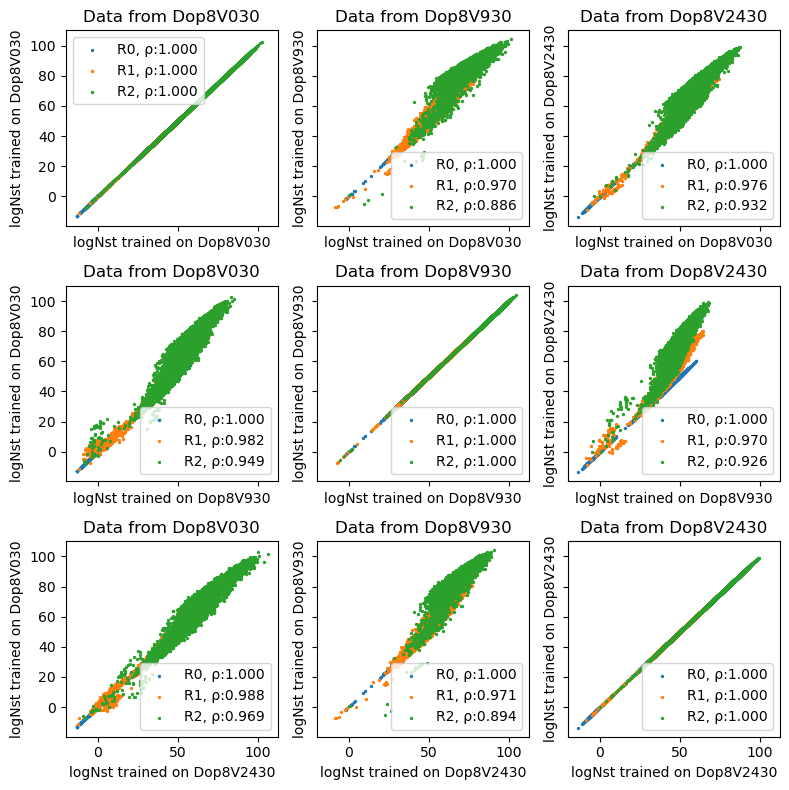

In [129]:
fig, axes = plt.subplots(3,3,figsize=(8,8), sharex=True, sharey=True)

for m in ns:
    for n in ns:
        ax = axes[m,n]
        for t in ts:
            ax.scatter(X[n][m][t], Y[n][m][t], label=f"R{t}, ρ:{pearsons[n][m][t]:.3f}", s=2)
            ax.set_xlabel("logNst trained on " + experiment_ids[m])
            ax.set_ylabel("logNst trained on " + experiment_ids[n])
            ax.set_title("Data from " + experiment_ids[n])
            ax.legend()
plt.tight_layout()
plt.savefig('img/logNst_ownNs0.png')

## Explore parameters

In [178]:
n = 0
J = params_zerosum_all[n]['couplings_ps']

def get_block(J,i,j):
    return J[i,:,j,:]

get_block(J, 0, 1)

k = 2
Jdiag = [J[i,:,i+k] for i in range(J.size(0)-k)]

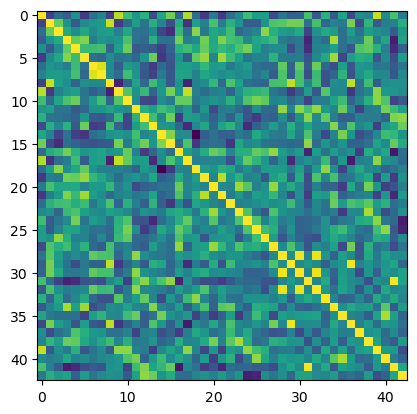

In [179]:
MJ = torch.stack([J.reshape(-1) for J in Jdiag])
plt.imshow(torch.corrcoef(MJ))

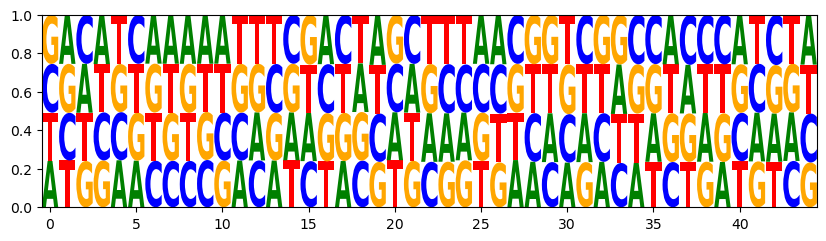

In [166]:
n = 0

x = utils.normalize_to_prob(params_zerosum_all[n]['bias_ps'].exp())
df = pd.DataFrame(x, columns=['A', 'C', 'G', 'T'])
logomaker.Logo(df)